[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)

#### based on Fig. 3 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol import AerosolMarine, AerosolBoreal
from atmos_cloud_sim_uj_utils import show_plot
from PySDM.initialisation import spectral_sampling as spec_sampling
from PySDM.physics import si
import numpy as np
import os
from matplotlib import pyplot
import matplotlib
from joblib import Parallel, delayed
import numba

In [14]:
from PySDM.physics.surface_tension import compressed_film
compressed_film.sgm_org = 40 * si.mN / si.m
compressed_film.delta_min = 0.1 * si.nm  # TODO #604 0.2 in the paper, but 0.1 matches the paper plots

In [3]:
numba.config.NUMBA_NUM_THREADS=2
rtol_x = 1e-3
rtol_thd = 1e-3

In [4]:
CI = 'CI' in os.environ

updraft_list = np.geomspace(0.1, 10, 2 if CI else 7)
forg_list = np.linspace(0.1, 0.9, 2 if CI else 7)
subplot_list = ["a","b","c","d"]
models = ('bulk', 'film')

Acc = {"a": 30, "b": 134, "c": 160, "d": 540}

In [5]:
def compute(key, settings):
    settings.output_interval = 1.0 * si.s
    settings.rtol_x = rtol_x
    settings.rtol_thd = rtol_thd
    simulation = Simulation(settings)
    output = simulation.run()
    output['updraft'] = settings.w
    output['org_fraction'] = settings.aerosol.aerosol_modes_per_cc[0]['f_org']
    output['color'] = settings.aerosol.color
    return key, output

print(f'tasks scheduled: {len(models) * len(subplot_list) * len(forg_list) * len(updraft_list)}')
output = dict(Parallel(verbose=10, n_jobs=-2)(
    delayed(compute)(subplot+"_w{:.2f}_f{:.2f}_".format(w,Forg)+model, Settings(
        dt = 0.1 * si.s, 
        n_sd_per_mode = 512, 
        model = model,
        aerosol = {
            "a": AerosolMarine(Acc_Forg=Forg, Acc_N2=Acc["a"]), 
            "b": AerosolMarine(Acc_Forg=Forg, Acc_N2=Acc["b"]), 
            "c": AerosolBoreal(Acc_Forg=Forg, Acc_N2=Acc["c"]), 
            "d": AerosolBoreal(Acc_Forg=Forg, Acc_N2=Acc["d"])
        }[subplot],
        w = w * si.m / si.s,
        spectral_sampling = spec_sampling.ConstantMultiplicity
    ))
    for w in updraft_list
    for Forg in forg_list
    for subplot in subplot_list
    for model in models
))

tasks scheduled: 392


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-2)]: Done  55 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-2)]: Done  66 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-2)]: Done  79 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-2)]: Done  92 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-2)]: Done 107 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-2)]: Done 122 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-2)]: Done 139 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed: 16

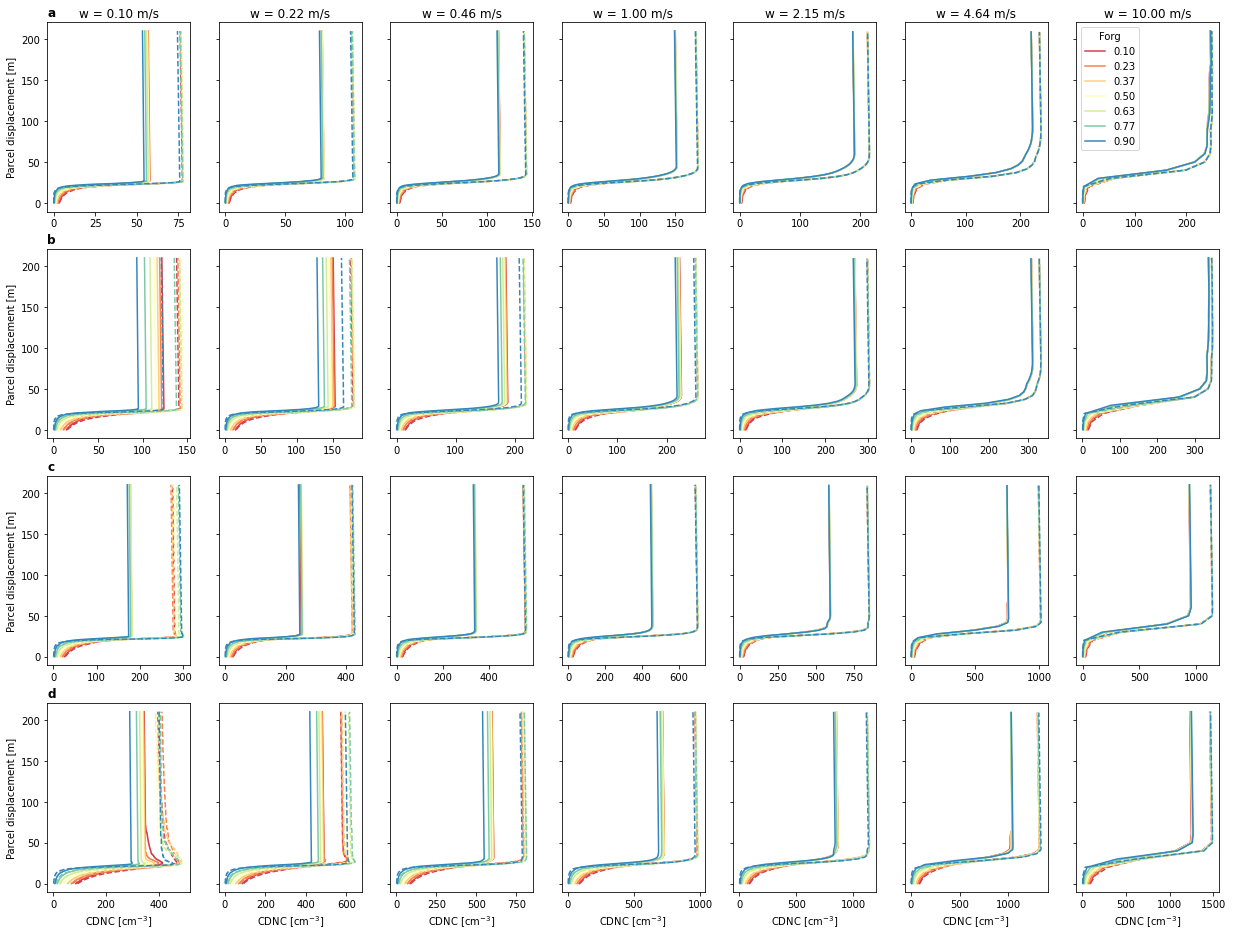

In [9]:
fig,axes = pyplot.subplots(len(subplot_list),len(updraft_list), sharex=False, sharey=True, figsize=(3*len(updraft_list),4*len(subplot_list)))

for k,subplot in enumerate(subplot_list):
    for i,w in enumerate(updraft_list):
        for j,Forg in enumerate(forg_list):
                key = subplot+"_w{:.2f}_f{:.2f}_".format(w,Forg)
                var = 'n_c_cm3'
                z = np.array(output[key+"film"]['z'])
                CDNC_film = np.array(output[key+"film"][var])
                CDNC_bulk = np.array(output[key+"bulk"][var])
                
                cmap = matplotlib.cm.get_cmap('Spectral')
                ax = axes[k,i]
                
                ax.plot(CDNC_film, z, "--", color=cmap(Forg))
                ax.plot(CDNC_bulk, z, "-", color=cmap(Forg), label="{:.2f}".format(Forg))
                #ax.plot((CDNC_film - CDNC_bulk) / CDNC_bulk * 100, z, "-", color=cmap(Forg), label="{:.2f}".format(Forg))
                
                if i == 0:
                    ax.set_ylabel("Parcel displacement [m]")
                    ax.set_title(subplot, loc="left", weight="bold")
                if i == len(updraft_list)-1 and k == 0:
                    ax.legend(title="Forg", loc=2)
                if k == 0:
                    ax.set_title("w = {:.2f} m/s".format(w))
                if k == len(subplot_list)-1:
                    #ax.set_xlabel("$\Delta$CDNC [%]")
                    ax.set_xlabel("CDNC [cm$^{-3}$]")
                    #ax.set_xlim([0,75])

pyplot.savefig("fig3-parcel-profiles.png",dpi=200)
pyplot.show()

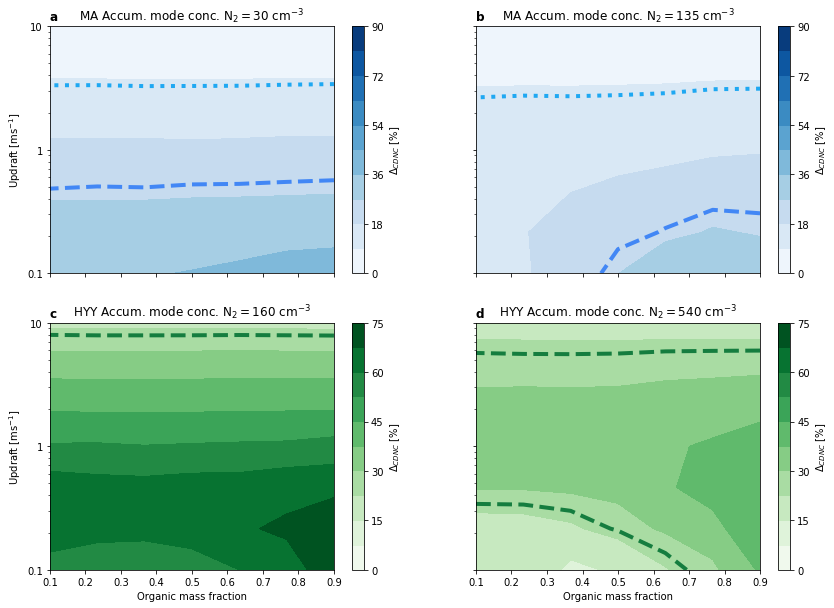

In [13]:
fig, axes = pyplot.subplots(2,2, sharex=True, sharey=True, figsize=(14,10))

for subplot in subplot_list:
    dCDNC = np.zeros((len(updraft_list), len(forg_list)))
    for i,w in enumerate(updraft_list):
        for j,Forg in enumerate(forg_list):
            key = subplot+"_w{:.2f}_f{:.2f}_".format(w,Forg)
            var = 'n_c_cm3'
            z = np.array(output[key+"film"]['z'])
            wz = np.where(z == z[-1])[0][0]
            CDNC_film = np.array(output[key+"film"][var])[wz]
            CDNC_bulk = np.array(output[key+"bulk"][var])[wz]
            dCDNC[i,j] = (CDNC_film - CDNC_bulk) / CDNC_bulk * 100.0
            #print(w, Forg, CDNC_bulk, CDNC_film, dCDNC[i,j])

    if subplot == "a":
        ax = axes[0,0]
        ax.set_title("MA Accum. mode conc. N$_2 = 30$ cm$^{-3}$")
        ax.contour(forg_list, updraft_list, dCDNC, levels=[10,25], colors=["#1fa8f2","#4287f5"], 
                       linestyles=[":","--"], linewidths=4)
        p = ax.contourf(forg_list, updraft_list, dCDNC, cmap="Blues", levels=np.linspace(0,90,11))
    if subplot == "b":
        ax = axes[0,1]
        ax.set_title("MA Accum. mode conc. N$_2 = 135$ cm$^{-3}$")
        ax.contour(forg_list, updraft_list, dCDNC, levels=[10,25], colors=["#1fa8f2","#4287f5"], 
                       linestyles=[":","--"], linewidths=4)
        p = ax.contourf(forg_list, updraft_list, dCDNC, cmap="Blues", levels=np.linspace(0,90,11))
    if subplot == "c":
        ax = axes[1,0]
        ax.set_title("HYY Accum. mode conc. N$_2 = 160$ cm$^{-3}$")
        ax.contour(forg_list, updraft_list, dCDNC, levels=[10,25], colors=["#04c753","#157d3f"], 
                       linestyles=[":","--"], linewidths=4)
        p = ax.contourf(forg_list, updraft_list, dCDNC, cmap="Greens", levels=np.linspace(0,75,11))
    if subplot == "d":
        ax = axes[1,1]
        ax.set_title("HYY Accum. mode conc. N$_2 = 540$ cm$^{-3}$")
        ax.contour(forg_list, updraft_list, dCDNC, levels=[10,25], colors=["#04c753","#157d3f"], 
                       linestyles=[":","--"], linewidths=4)
        p = ax.contourf(forg_list, updraft_list, dCDNC, cmap="Greens", levels=np.linspace(0,75,11))
        
    ax.set_title(subplot,weight="bold",loc="left")
    if subplot == "c" or subplot == "d":
        ax.set_xlabel("Organic mass fraction")
    ax.set_yscale("log")
    ax.set_yticks([0.1,1,10])
    ax.set_yticklabels(["0.1","1","10"])
    if subplot == "a" or subplot == "c":
        ax.set_ylabel("Updraft [ms$^{-1}$]")
    pyplot.colorbar(p, ax=ax, label="$\Delta_{CDNC}$ [%]")

pyplot.savefig("fig3.png", dpi=100)
pyplot.show()
#show_plot()